# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [ ]:
# use preloaded keras datasets and models
! mkdir -p ~/.keras/datasets
! mkdir -p ~/.keras/models
! ln -s $(realpath ../readonly/keras/datasets/*) ~/.keras/datasets/
! ln -s $(realpath ../readonly/keras/models/*) ~/.keras/models/

In [34]:
# 1 GPU for TensorFlow
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# 2 CPU cores for TensorFlow
import tensorflow as tf
import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
config = tf.ConfigProto(
    device_count={'CPU': 1},
    intra_op_parallelism_threads=32,
    inter_op_parallelism_threads=32
)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [4]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading
import grading_utils

# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [5]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [6]:
# token expires every 30 min
COURSERA_TOKEN = "AE46k478qyWQEkID"
COURSERA_EMAIL = "zimovnov@gmail.com"

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [ ]:
# link prepared files here
! ln -s $(realpath ../readonly/week6/*) .

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [7]:
IMG_SIZE = 299

In [8]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(0)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.engine.training.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
K.clear_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [9]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [10]:
# check prepared samples of images
! ls *_sample.zip

train2014_sample.zip val2014_sample.zip


# Extract captions for images

In [11]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


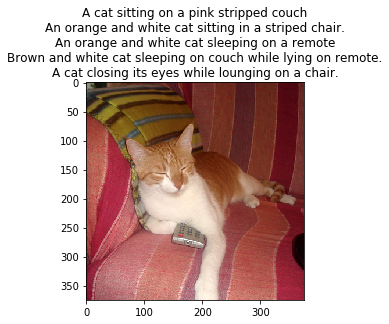

In [12]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [13]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [14]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    vocab = defaultdict(int)
    for caps in train_captions:
        for cap in caps:
            for token in split_sentence(cap):
                vocab[token] += 1
    vocab = [token for token, count in vocab.items() if count >= 5]
    vocab.extend([PAD, UNK, START, END])
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    unk_idx = vocab[UNK]
    res = []
    for caps in captions:
        res_for_image = []
        for cap in caps:
            cap_indices = list(map(lambda token: vocab.get(token, unk_idx),
                                   [START] + split_sentence(cap) + [END]))
            res_for_image.append(cap_indices)
        res.append(res_for_image)
    return res

In [15]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [16]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an euqal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [17]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with vocab[PAD] where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, vocab[PAD]]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, vocab[PAD]]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len is None:
        max_len = max(map(len, batch_captions))
    else:
        max_len = min(max_len, max(map(len, batch_captions)))
    matrix = np.zeros((len(batch_captions), max_len), dtype='int32') + pad_idx
    for row_idx, row in enumerate(batch_captions):
        row = row[:max_len]
        matrix[row_idx, :len(row)] = row
    return matrix

In [18]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [19]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [20]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [21]:
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

In [22]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits` layer
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not vocab[PAD]) and 0.0 otherwise.
    flat_loss_mask = tf.cast(tf.not_equal(flat_ground_truth, pad_idx), 'float32')

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_sum(xent * flat_loss_mask) / tf.reduce_sum(flat_loss_mask)

In [23]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [24]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [25]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [26]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [27]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    # sample random images indices
    random_images_idx = np.random.randint(0, len(images_embeddings), size=batch_size)
    batch_image_embeddings = images_embeddings[random_images_idx]
    
    # pick 1 from several captions for each image
    batch_captions = list(map(choice, indexed_captions[random_images_idx]))
    # convert batch_captions to matrix
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [28]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [29]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
saver.restore(s, "weights")

INFO:tensorflow:Restoring parameters from weights


Look at the training and validation loss, they should be decreasing!

In [522]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    
    # save weights after finishing epoch
    saver.save(s, "weights_{}".format(epoch))

print("Finished!")

A Jupyter Widget



Epoch: 0, train loss: 4.2846772933006285, val loss: 3.690255753993988


A Jupyter Widget


Epoch: 1, train loss: 3.370911339521408, val loss: 3.1811022210121154


A Jupyter Widget


Epoch: 2, train loss: 3.0211814792156217, val loss: 2.950054807662964


A Jupyter Widget


Epoch: 3, train loss: 2.859246516942978, val loss: 2.883252420425415


A Jupyter Widget


Epoch: 4, train loss: 2.7620893971920015, val loss: 2.7779859352111815


A Jupyter Widget


Epoch: 5, train loss: 2.688210505723953, val loss: 2.7427035760879517


A Jupyter Widget


Epoch: 6, train loss: 2.643444278717041, val loss: 2.7007285380363464


A Jupyter Widget


Epoch: 7, train loss: 2.6016485965251923, val loss: 2.6718317341804503


A Jupyter Widget


Epoch: 8, train loss: 2.56570934176445, val loss: 2.6157714533805847


A Jupyter Widget


Epoch: 9, train loss: 2.5382546179294585, val loss: 2.614688639640808


A Jupyter Widget


Epoch: 10, train loss: 2.5180493042469023, val loss: 2.6119805550575257


A Jupyter Widget


Epoch: 11, train loss: 2.480334274530411, val loss: 2.5920819807052613
Finished!


In [30]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

In [31]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [25]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.47434
Accuracy: 0.505913272011
Example 0
Predicted: a dog is laying at at the cat table #END# #UNK# the the cat #END# the floor #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: the chihuahua is looking up at the wooden structure rather than at the moose on the ground #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man standing standing in a kitchen kitchen #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a woman is standing in a large garage #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a donuts of doughnuts are on a bakery case #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# and and and and and and and and
Truth: several varieties of donuts are in a glass display case #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #P

In [26]:
# save graph weights to file!
saver.save(s, "weights")

'weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [530]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, "weights")  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from weights


In [531]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [532]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player swinging a bat at a game


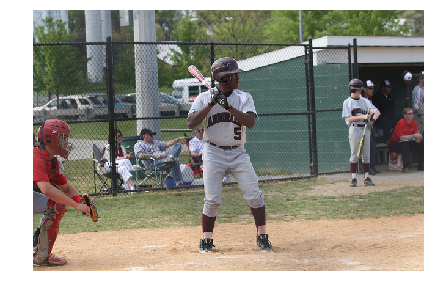

In [533]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a group of people are swimming in the water


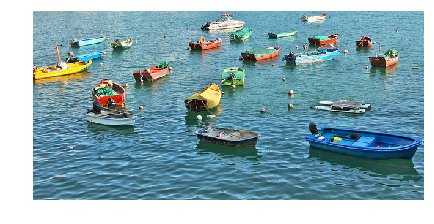

a plane flying over a large body of water


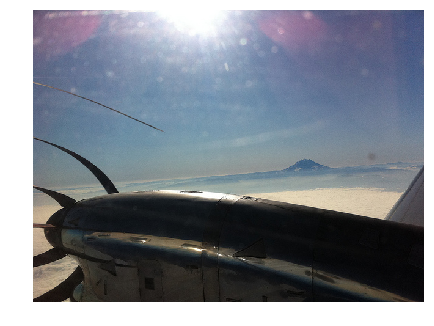

a bed with a lamp and a window


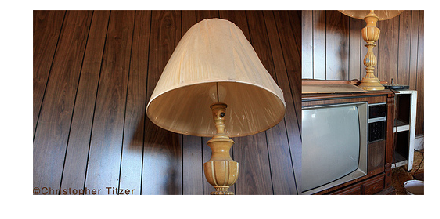

a giraffe standing in a field with trees in the background


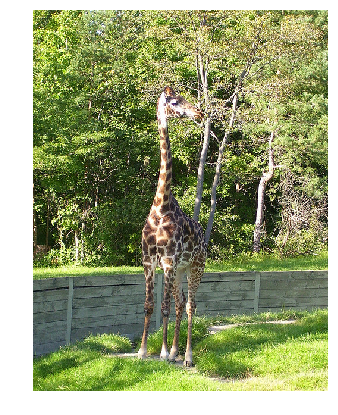

a young child is playing with a wii remote


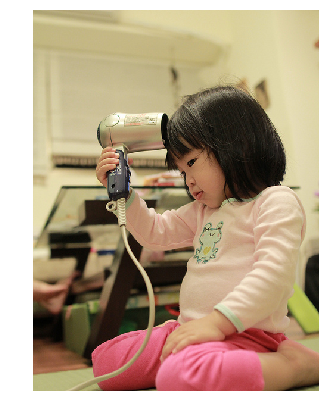

a man with a dog is standing in a bed


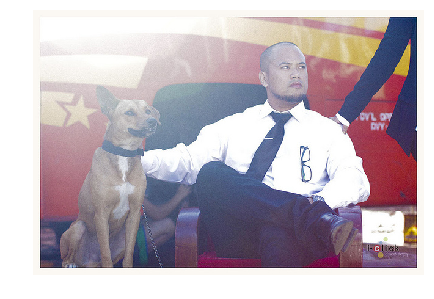

a man is using a cell phone in a room


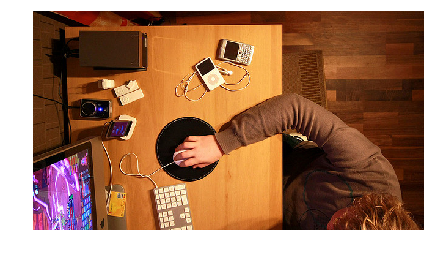

a fire hydrant is in the middle of a street


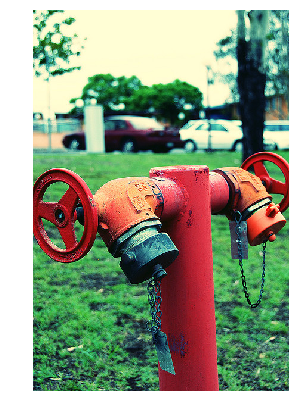

a woman is standing on a horse in the middle of a field


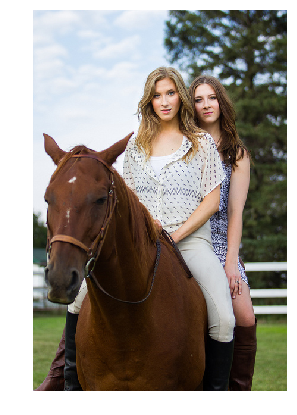

a bear is standing in a forest field


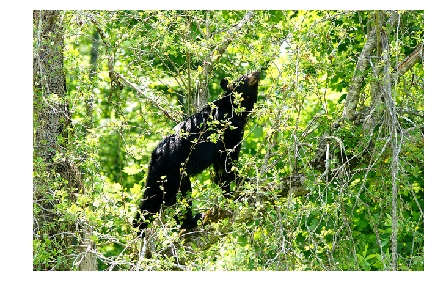

In [534]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [342]:
! wget http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg

--2017-09-24 02:10:17--  http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg
Resolving www.bijouxandbits.com (www.bijouxandbits.com)... 64:ff9b::2d37:2d31
Connecting to www.bijouxandbits.com (www.bijouxandbits.com)|64:ff9b::2d37:2d31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273364 (267K) [image/jpeg]
Saving to: ‘portal-cake-10.jpg’

100%[======================================>] 273,364      553KB/s   in 0.5s   

2017-09-24 02:10:18 (553 KB/s) - ‘portal-cake-10.jpg’ saved [273364/273364]



a cake with a chocolate cake on it


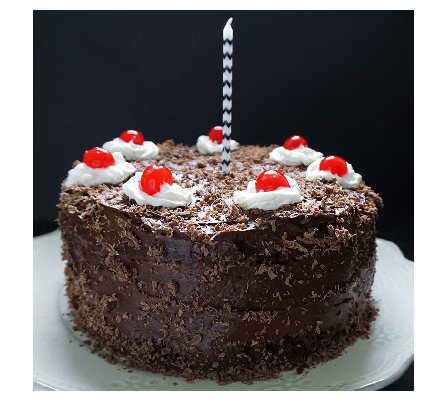

In [353]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

In [ ]:
### YOUR EXAMPLES HERE ###

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!